**Importing Libraries**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


In [16]:
df = pd.read_csv('/content/ecommerce_recommendation_dataset.csv')
df.head()

,user_id,product_id,category,price,rating,review_count,user_age,user_gender,user_location,purchase_history,...,product_rating_variance,review_sentiment_score,user_engagement_score,ad_click_rate,time_of_day,day_of_week,season,payment_method,coupon_used,product_popularity
0,78517,1645,Books,842.23,2,155,24,Other,Urban,False,...,0.13,-0.28,0.68,0.04,Night,Thursday,Summer,Debit Card,False,0.54
1,52887,100,Books,253.76,3,331,43,Other,Suburban,False,...,0.02,0.28,0.11,0.89,Morning,Saturday,Summer,Debit Card,False,0.77
2,59395,585,Books,483.65,2,236,64,Female,Rural,True,...,1.55,0.23,0.35,0.99,Evening,Tuesday,Fall,Debit Card,False,0.14
3,54739,3774,Groceries,459.37,2,227,34,Female,Urban,False,...,1.41,0.93,0.73,0.16,Afternoon,Tuesday,Spring,Credit Card,False,0.18
4,42723,2119,Groceries,150.11,2,214,51,Female,Urban,True,...,1.29,0.11,0.26,0.17,Night,Wednesday,Spring,PayPal,False,0.66


**Data Exploration and cleaning**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  60000 non-null  int64  
 1   product_id               60000 non-null  int64  
 2   category                 60000 non-null  object 
 3   price                    60000 non-null  float64
 4   rating                   60000 non-null  int64  
 5   review_count             60000 non-null  int64  
 6   user_age                 60000 non-null  int64  
 7   user_gender              60000 non-null  object 
 8   user_location            60000 non-null  object 
 9   purchase_history         60000 non-null  bool   
 10  time_on_page             60000 non-null  float64
 11  add_to_cart_count        60000 non-null  int64  
 12  search_keywords          60000 non-null  object 
 13  discount_applied         60000 non-null  bool   
 14  user_membership       

In [18]:
df.isnull().sum().sum()

np.int64(0)

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
# 1. Convert purchase_time to datetime
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# 2. Checking the unique values in categorical columns to ensure consistency
categorical_cols = ['category', 'user_gender', 'user_membership', 'stock_status']
for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

# 3. Verify the transformation
print("\nNew Data Types:")
print(df[['purchase_time']].dtypes)

Unique values in category: ['Books' 'Groceries' 'Electronics' 'Furniture' 'Clothing']
Unique values in user_gender: ['Other' 'Female' 'Male']
Unique values in user_membership: ['Free' 'Silver' 'Gold' 'Platinum']
Unique values in stock_status: ['High' 'Low' 'Medium']

New Data Types:
purchase_time    datetime64[ns]
dtype: object


**Exploratory Data Analysis (EDA)**

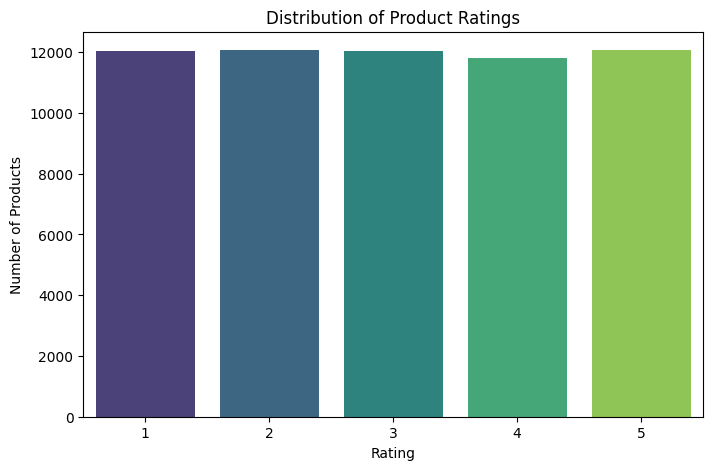

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Products')
plt.show()

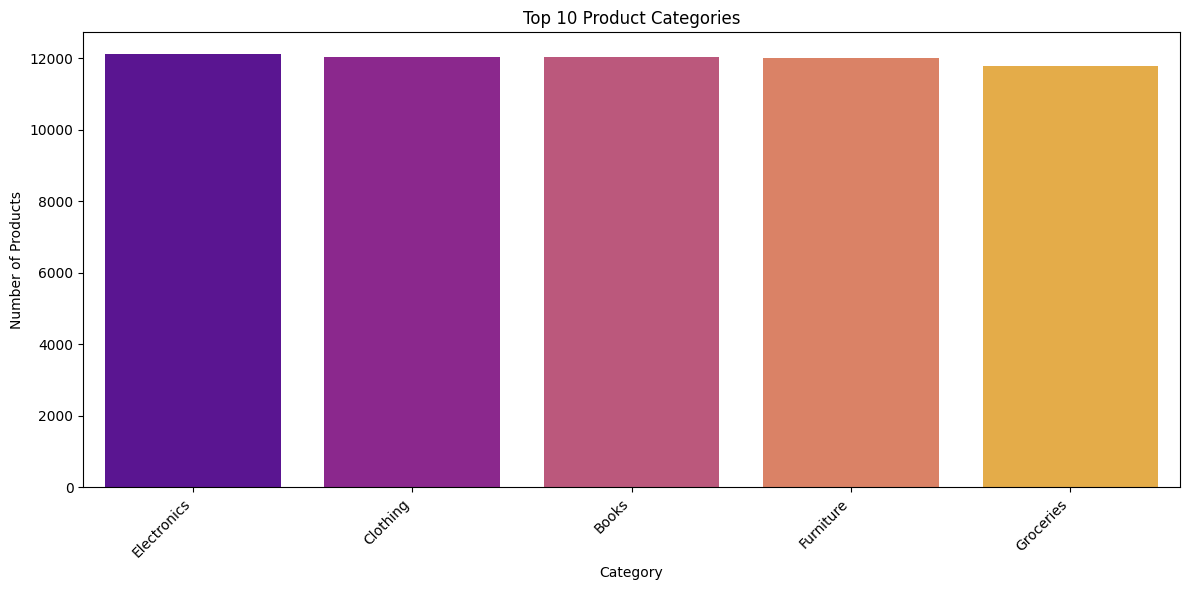

In [22]:
top_10_categories = df['category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='plasma')
plt.title('Top 10 Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

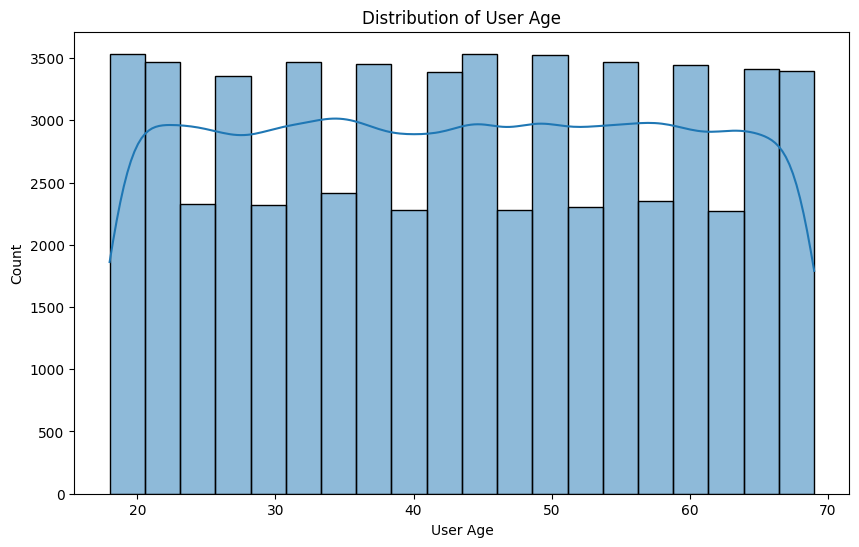

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['user_age'], bins=20, kde=True, palette='viridis')
plt.title('Distribution of User Age')
plt.xlabel('User Age')
plt.ylabel('Count')
plt.show()

In [24]:
# Calculate the number of unique users and products
n_users = df['user_id'].nunique()
n_items = df['product_id'].nunique()
n_ratings = len(df)

print(f"Number of unique users: {n_users}")
print(f"Number of unique products: {n_items}")
print(f"Sparsity: {1 - n_ratings / (n_users * n_items):.4%}")

# Average ratings per user
user_counts = df.groupby('user_id').size()
print(f"\nAverage ratings per user: {user_counts.mean():.2f}")
print(f"Max ratings by a single user: {user_counts.max()}")

Number of unique users: 45154
Number of unique products: 4999
Sparsity: 99.9734%

Average ratings per user: 1.33
Max ratings by a single user: 6


**Statistical Analysis and outlier detection**

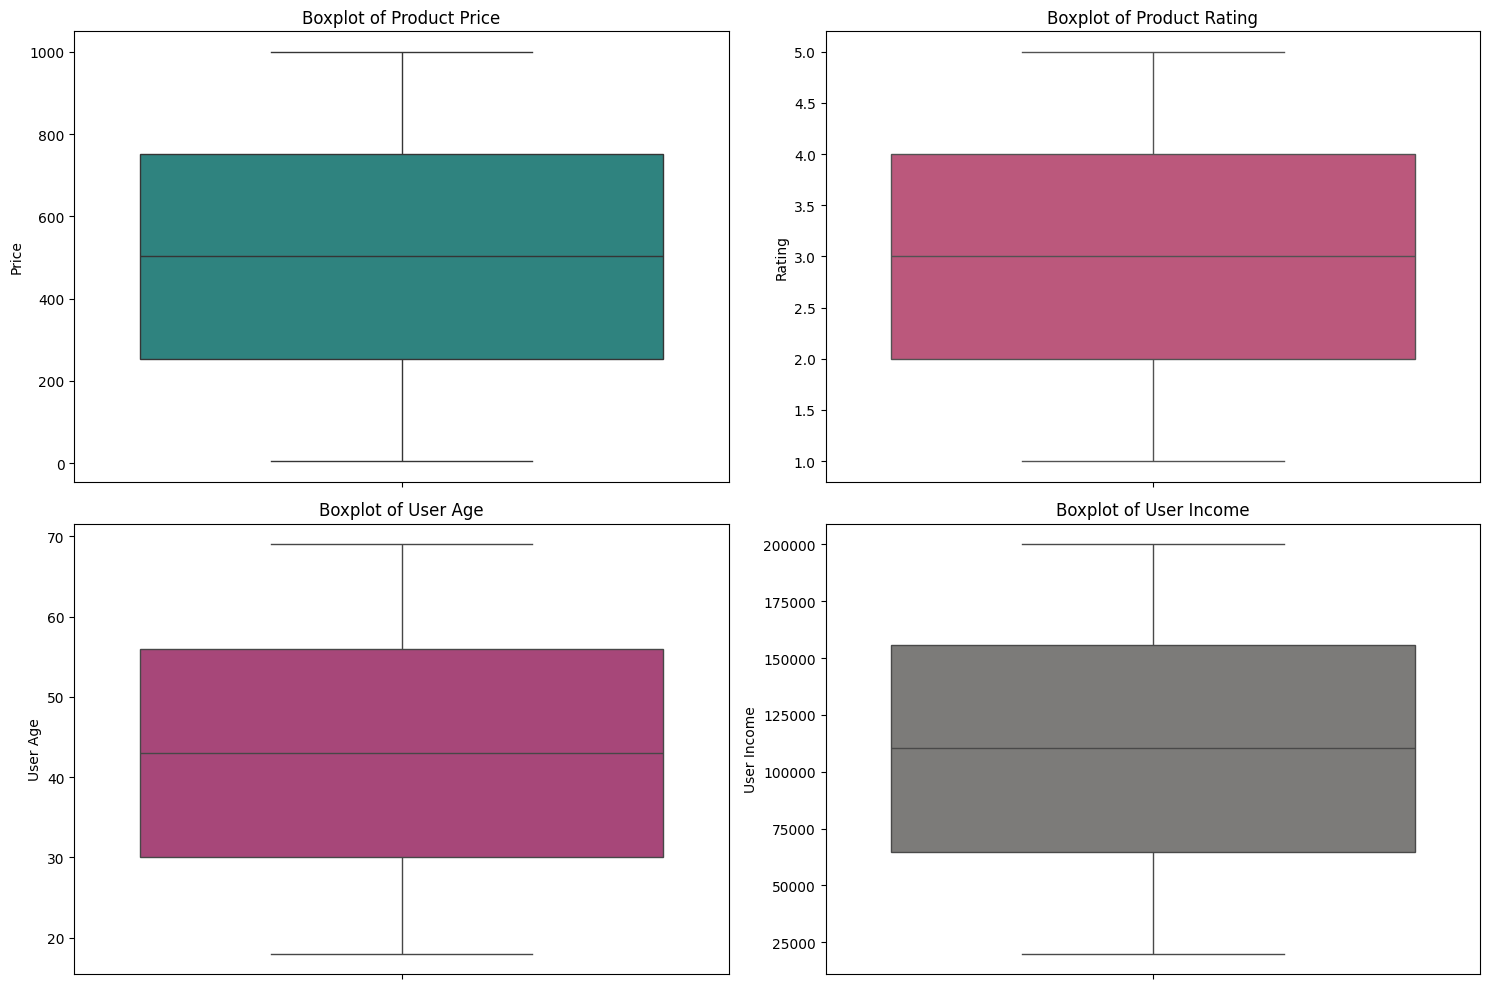

In [25]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df['price'], palette='viridis')
plt.title('Boxplot of Product Price')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['rating'], palette='plasma')
plt.title('Boxplot of Product Rating')
plt.ylabel('Rating')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['user_age'], palette='magma')
plt.title('Boxplot of User Age')
plt.ylabel('User Age')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['user_income'], palette='cividis')
plt.title('Boxplot of User Income')
plt.ylabel('User Income')

plt.tight_layout()
plt.show()

In [26]:
# Check if any product_id is associated with multiple categories (which would be an error)
product_category_check = df.groupby('product_id')['category'].nunique()
invalid_products = product_category_check[product_category_check > 1]

if invalid_products.empty:
    print("Success: Every product is mapped to exactly one category.")
else:
    print("Warning: Some products have multiple categories assigned:")
    print(invalid_products)

# Check for zero or negative prices (sanity check)
negative_prices = df[df['price'] <= 0]
print(f"Number of rows with invalid prices: {len(negative_prices)}")

product_id
1       5
2       4
3       5
4       5
5       5
       ..
4995    5
4996    5
4997    5
4998    5
4999    3
Name: category, Length: 4997, dtype: int64
Number of rows with invalid prices: 0


**Creating Unique Product ID's**

In [27]:
# 1. Create a truly unique ID for each product within its category
df['unique_item_id'] = df['category'] + "_" + df['product_id'].astype(str)

# 2. Verify the fix
unique_products = df['unique_item_id'].nunique()
print(f"Original Product IDs: {df['product_id'].nunique()}")
print(f"New Unique Item IDs: {unique_products}")

# 3. Drop any columns that are too redundant or won't help the model
# For a basic recommendation system, we might not need 'search_keywords'
# or 'user_browser' immediately, but we'll keep them for now.

# 4. Check the density of the new Unique IDs
interactions_per_item = df.groupby('unique_item_id').size()
print(f"\nAverage interactions per unique item: {interactions_per_item.mean():.2f}")

Original Product IDs: 4999
New Unique Item IDs: 22750

Average interactions per unique item: 2.64


**Evaluvating User Engagement & Feature Selection**

In [28]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize LabelEncoder
le = LabelEncoder()

# 2. Select key categorical columns to encode
categorical_features = [
    'user_gender', 'user_location', 'user_membership',
    'user_education', 'user_marital_status', 'stock_status',
    'product_color', 'product_size', 'season', 'payment_method'
]

# 3. Apply encoding
for col in categorical_features:
    df[f'{col}_encoded'] = le.fit_transform(df[col])

# 4. Binary encoding for True/False columns
df['is_top_seller_encoded'] = df['is_top_seller'].astype(int)
df['discount_applied_encoded'] = df['discount_applied'].astype(int)

# 5. Let's look at our new "Feature-Rich" dataframe
encoded_cols = [c for c in df.columns if '_encoded' in c]
print("Encoded Features Preview:")
print(df[encoded_cols].head())

print(f"\nTotal columns now: {len(df.columns)}")

Encoded Features Preview:
   user_gender_encoded  user_location_encoded  user_membership_encoded  \
0                    2                      2                        0   
1                    2                      1                        3   
2                    0                      0                        1   
3                    0                      2                        2   
4                    0                      2                        1   

   user_education_encoded  user_marital_status_encoded  stock_status_encoded  \
0                       2                            0                     0   
1                       3                            3                     1   
2                       2                            3                     0   
3                       1                            1                     0   
4                       1                            1                     1   

   product_color_encoded  product_size_encoded  

**Analyzing Correlations**

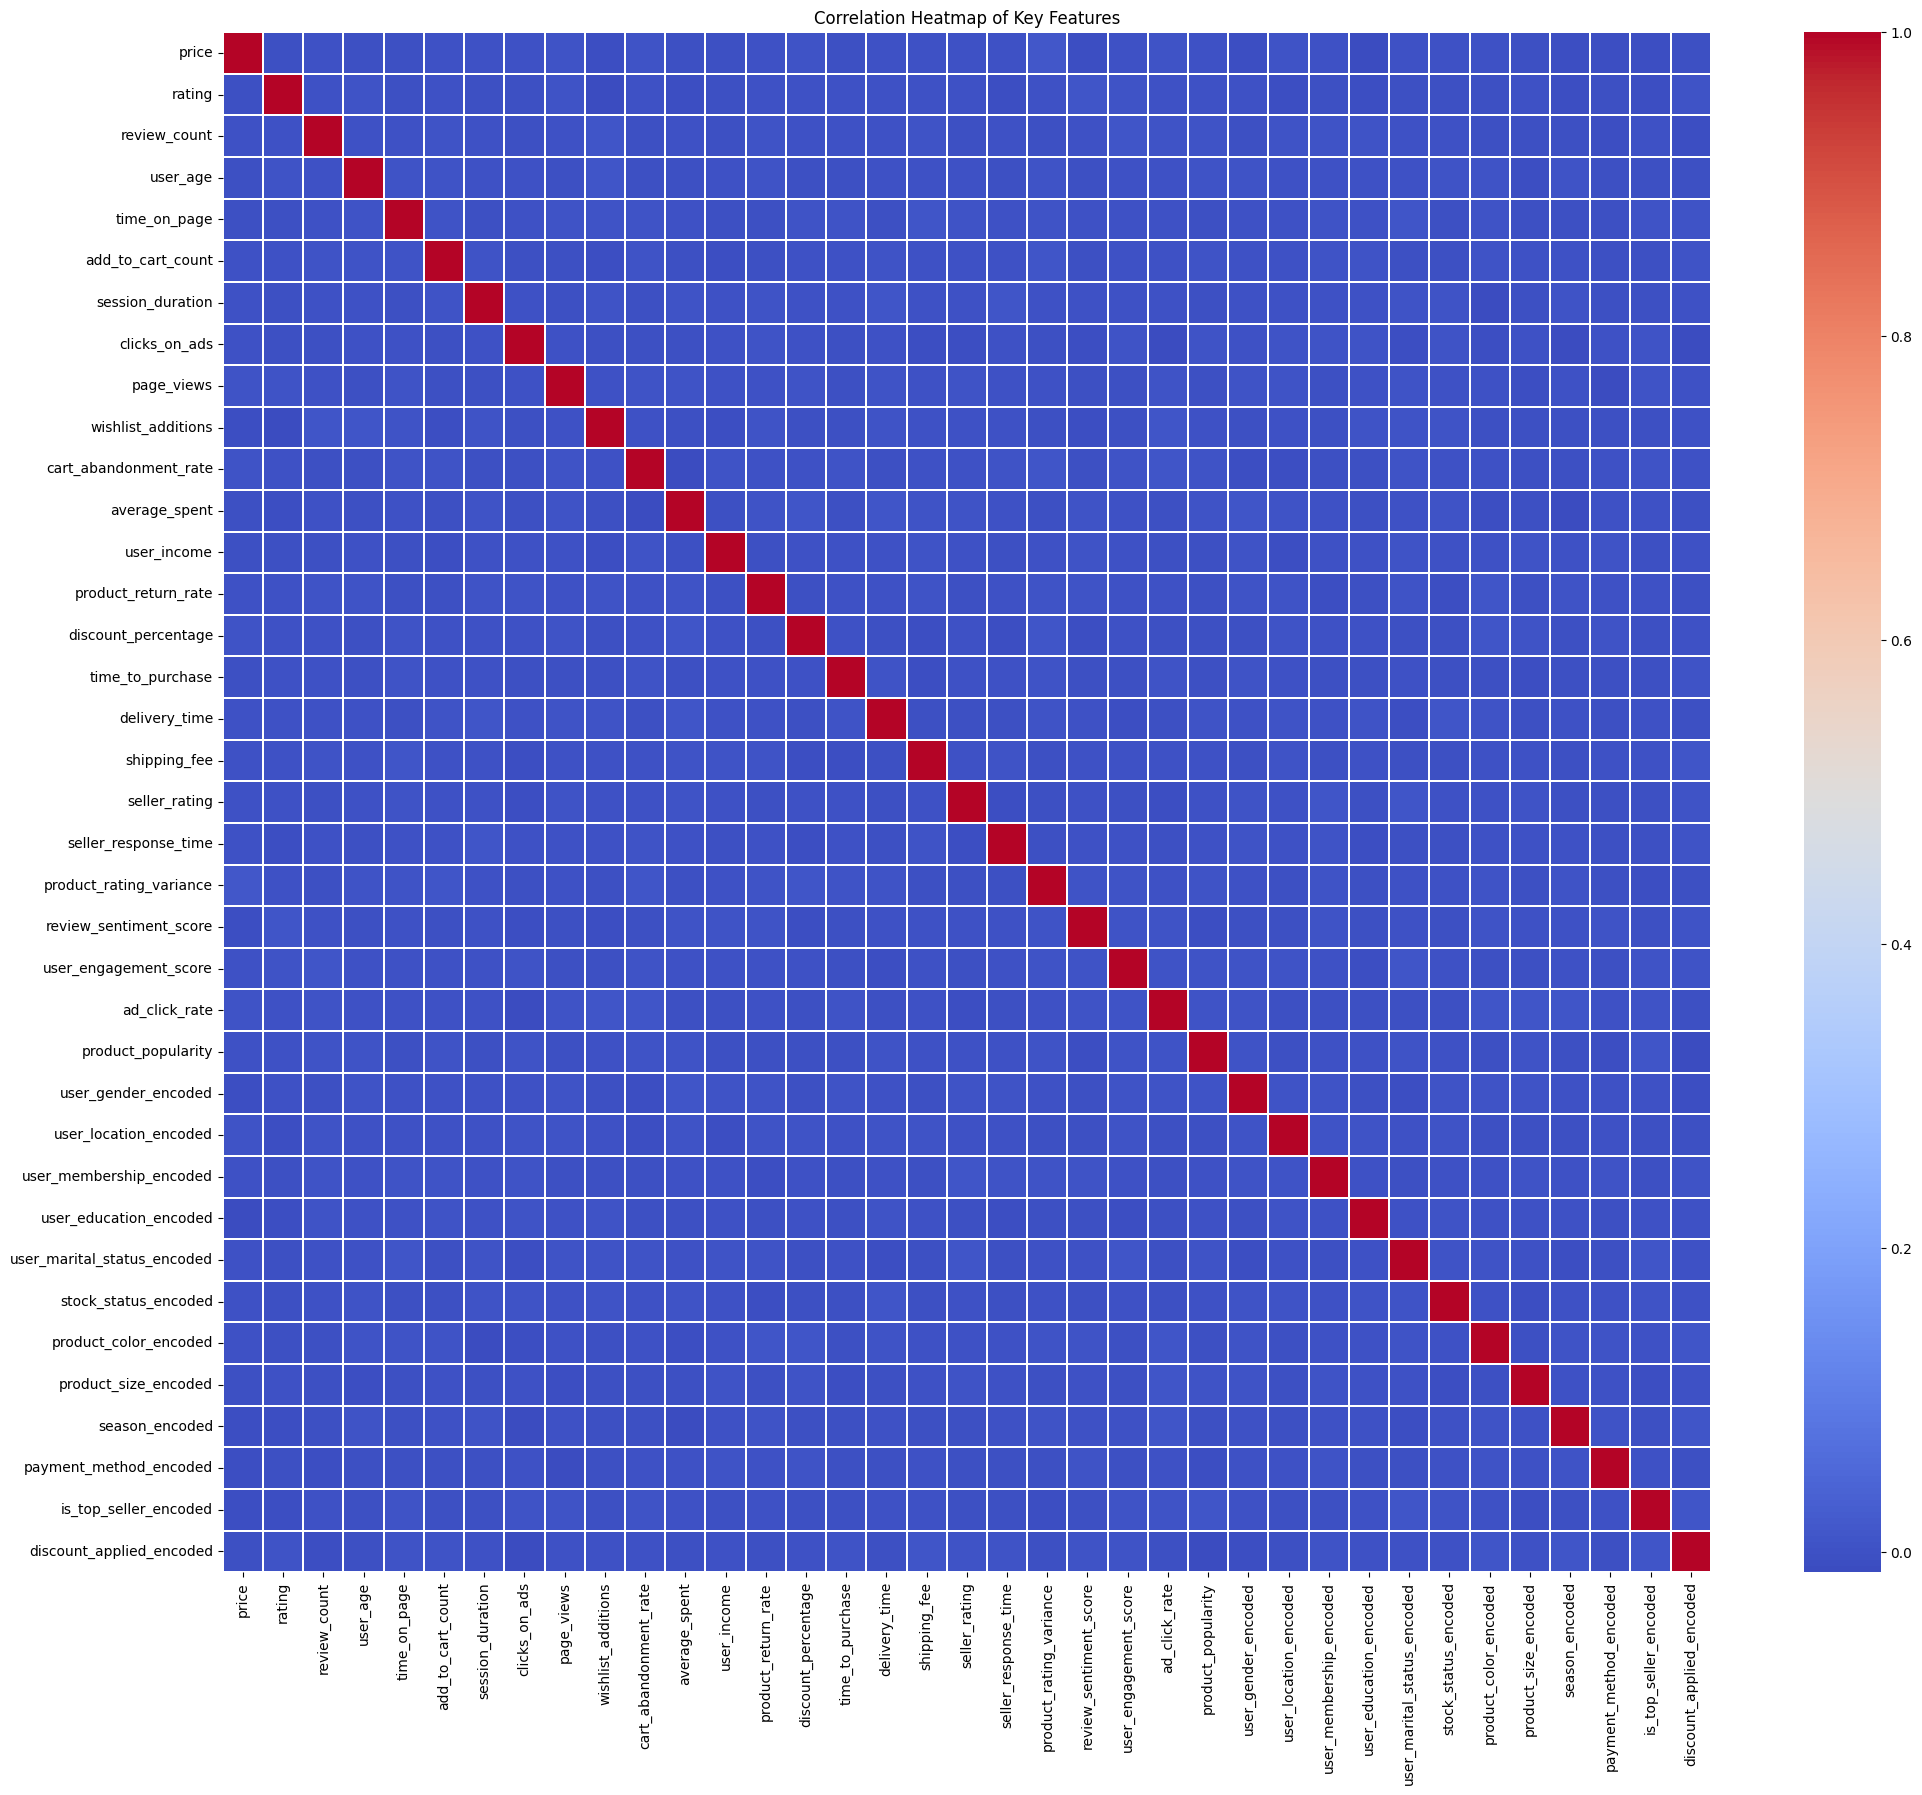

In [29]:
# Select relevant numerical and encoded categorical features for correlation analysis
correlation_features = df[[
    'price', 'rating', 'review_count', 'user_age', 'time_on_page',
    'add_to_cart_count', 'session_duration', 'clicks_on_ads', 'page_views',
    'wishlist_additions', 'cart_abandonment_rate', 'average_spent',
    'user_income', 'product_return_rate', 'discount_percentage',
    'time_to_purchase', 'delivery_time', 'shipping_fee', 'seller_rating',
    'seller_response_time', 'product_rating_variance', 'review_sentiment_score',
    'user_engagement_score', 'ad_click_rate', 'product_popularity',
    'user_gender_encoded', 'user_location_encoded', 'user_membership_encoded',
    'user_education_encoded', 'user_marital_status_encoded', 'stock_status_encoded',
    'product_color_encoded', 'product_size_encoded', 'season_encoded',
    'payment_method_encoded', 'is_top_seller_encoded', 'discount_applied_encoded'
]]

# Calculate the correlation matrix
correlation_matrix = correlation_features.corr()

# Plot the heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.05)
plt.title('Correlation Heatmap of Key Features')
plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler

# 1. Select the numerical features we want to use for the recommendation engine
features_to_scale = [
    'price', 'user_age', 'user_income', 'time_on_page',
    'add_to_cart_count', 'session_duration', 'product_return_rate',
    'discount_percentage', 'user_engagement_score', 'product_popularity'
]

# 2. Initialize the Scaler
scaler = MinMaxScaler()

# 3. Apply scaling
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 4. Show the scaled data
print("Scaled Features (0 to 1 range):")
print(df[features_to_scale].head())

Scaled Features (0 to 1 range):
      price  user_age  user_income  time_on_page  add_to_cart_count  \
0  0.841444  0.117647     0.127212      0.452881           0.666667   
1  0.250005  0.490196     0.050487      0.424746           0.333333   
2  0.481055  0.901961     0.371452      0.110169           0.777778   
3  0.456652  0.313725     0.940217      0.186780           0.000000   
4  0.145832  0.647059     0.678824      0.216610           1.000000   

   session_duration  product_return_rate  discount_percentage  \
0          0.675727                 0.32               0.2162   
1          0.112875                 0.20               0.6096   
2          0.838536                 0.08               0.6556   
3          0.266459                 0.76               0.1784   
4          0.115020                 0.11               0.7194   

   user_engagement_score  product_popularity  
0                   0.68                0.54  
1                   0.11                0.77  
2        

**Splitting the Data for Training and Testing**

In [31]:
from sklearn.model_selection import train_test_split

# 1. Define our target and features
# In a recommendation system, we often want to predict the 'rating'
# or simply identify which 'unique_item_id' a 'user_id' will interact with.

# 2. Perform a 80/20 Split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training records: {len(train_data)}")
print(f"Testing records: {len(test_data)}")

# 3. Quick check: Do we have the same users in both?
train_users = set(train_data['user_id'])
test_users = set(test_data['user_id'])
new_users = test_users - train_users

print(f"Users in test set not seen in training (Cold Start users): {len(new_users)}")

Training records: 48000
Testing records: 12000
Users in test set not seen in training (Cold Start users): 6917


**Building a Popularity based Recommender**

In [32]:
# 1. Create a ranking of items based on weighted performance
# We combine 'rating' and 'product_popularity' for a balanced score
popularity_model = train_data.groupby(['category', 'unique_item_id']).agg({
    'rating': 'mean',
    'product_popularity': 'mean'
}).reset_index()

# 2. Sort by rating first, then by popularity
popularity_model = popularity_model.sort_values(by=['rating', 'product_popularity'], ascending=False)

# 3. Create a function to get Top N recommendations globally
def get_global_recommendations(n=5):
    return popularity_model.head(n)

# 4. Create a function to get Top N recommendations for a specific category
def get_category_recommendations(category_name, n=5):
    return popularity_model[popularity_model['category'] == category_name].head(n)

# --- Test the baseline ---
print("--- Global Top 5 Products ---")
print(get_global_recommendations(5)[['unique_item_id', 'rating', 'product_popularity']])

print("\n--- Top 5 Books ---")
print(get_category_recommendations('Books', 5)[['unique_item_id', 'rating', 'product_popularity']])

--- Global Top 5 Products ---
         unique_item_id  rating  product_popularity
424          Books_1448     5.0                 1.0
7195      Clothing_4135     5.0                 1.0
10334  Electronics_2901     5.0                 1.0
10959  Electronics_3558     5.0                 1.0
17690    Groceries_1622     5.0                 1.0

--- Top 5 Books ---
     unique_item_id  rating  product_popularity
424      Books_1448     5.0                1.00
1954      Books_306     5.0                0.99
3367     Books_4570     5.0                0.99
4034       Books_79     5.0                0.99
4106       Books_87     5.0                0.99


In [33]:
# Encode the category column which we missed earlier
le_cat = LabelEncoder()
df['category_encoded'] = le_cat.fit_transform(df['category'])

print(f"Successfully added 'category_encoded'. Unique categories: {df['category_encoded'].nunique()}")

Successfully added 'category_encoded'. Unique categories: 5


**Content-Based Filtering (Item - Item Similarity)**

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Define the features that describe the item
# We use the scaled numerical columns + the encoded categorical ones
product_feature_cols = [
    'category_encoded', 'price', 'product_color_encoded',
    'product_size_encoded', 'is_top_seller_encoded',
    'product_return_rate', 'seller_rating'
]

# 2. Create a representative profile for each unique item
# We take the mean in case there are slight variations in the logs
product_profiles = df.groupby('unique_item_id')[product_feature_cols].mean()

# 3. Optimized Function to get similar items (calculates similarity on-the-fly)
def get_content_based_recs(target_item_id, n=5):
    if target_item_id not in product_profiles.index:
        return "Item not found."

    # Get the features of the target item
    target_features = product_profiles.loc[[target_item_id]].values

    # Calculate similarity between this item and ALL other items
    # (This is much faster than pre-calculating the whole matrix)
    similarities = cosine_similarity(target_features, product_profiles.values).flatten()

    # Get the indices of the top N most similar items
    # We use argsort and take the last N+1 (excluding the item itself)
    related_indices = similarities.argsort()[-(n+1):-1][::-1]

    # Get the item IDs and their similarity scores
    recommendations = product_profiles.index[related_indices].tolist()
    scores = similarities[related_indices]

    return list(zip(recommendations, scores))

# Let's pick a 'Books' item as an example
example_item = df[df['category'] == 'Books']['unique_item_id'].iloc[0]
print(f"Because you looked at: {example_item}")
print("-" * 30)

recs = get_content_based_recs(example_item, 5)
for item, score in recs:
    print(f"Recommended: {item} | Similarity Score: {score:.4f}")

Because you looked at: Books_1645
------------------------------
Recommended: Books_1696 | Similarity Score: 0.9980
Recommended: Books_39 | Similarity Score: 0.9975
Recommended: Books_2416 | Similarity Score: 0.9975
Recommended: Books_2816 | Similarity Score: 0.9975
Recommended: Books_1538 | Similarity Score: 0.9973


**Collaborative Filtering (Matrix Factorization)**

In [35]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# 1. Map user_id and unique_item_id to numeric indices
user_map = {id: i for i, id in enumerate(df['user_id'].unique())}
item_map = {id: i for i, id in enumerate(df['unique_item_id'].unique())}

df['user_idx'] = df['user_id'].map(user_map)
df['item_idx'] = df['unique_item_id'].map(item_map)

# 2. Create a Sparse User-Item Matrix (saves memory)
# We use the ratings as values
user_item_matrix = csr_matrix(
    (df['rating'], (df['user_idx'], df['item_idx'])),
    shape=(len(user_map), len(item_map))
)

# 3. Apply SVD (Matrix Factorization)
# k=20 means we find 20 "hidden patterns" in user preferences
U, sigma, Vt = svds(user_item_matrix.astype(float), k=20)
sigma = np.diag(sigma)

# 4. Function to predict ratings for a specific user
def predict_ratings_for_user(user_id, n=5):
    if user_id not in user_map:
        return "User not found in training data (Cold Start)."

    user_idx = user_map[user_id]

    # Predict ratings for ALL items for this specific user
    user_prediction = np.dot(np.dot(U[user_idx, :], sigma), Vt)

    # Get indices of top N items
    top_item_indices = user_prediction.argsort()[-n:][::-1]

    # Map back to item IDs
    recommended_items = [list(item_map.keys())[list(item_map.values()).index(i)] for i in top_item_indices]
    predicted_scores = user_prediction[top_item_indices]

    return list(zip(recommended_items, predicted_scores))

# --- Test the Collaborative Recommender ---
# Pick a user who has interaction history
example_user = df['user_id'].iloc[0]
print(f"Collaborative Recommendations for User {example_user}:")
print("-" * 40)
cf_recs = predict_ratings_for_user(example_user, 5)

if isinstance(cf_recs, str):
    print(cf_recs)
else:
    for item, score in cf_recs:
        print(f"Recommended: {item} | Predicted Interest: {score:.4f}")

Collaborative Recommendations for User 78517:
----------------------------------------
Recommended: Clothing_2238 | Predicted Interest: 0.0000
Recommended: Clothing_3844 | Predicted Interest: 0.0000
Recommended: Clothing_4494 | Predicted Interest: 0.0000
Recommended: Groceries_3308 | Predicted Interest: 0.0000
Recommended: Groceries_2536 | Predicted Interest: 0.0000


**Building the Hybrid Recommender**

The 0.0000 scores in the previous step happened because the dataset is very "sparse"—most users have only bought one thing, so the SVD model doesn't have enough "social" data to predict their future taste accurately.

This is exactly why professional platforms like Amazon or Netflix use a Hybrid System. A Hybrid system combines:
1. Collaborative Filtering (What people like you bought).
2. Content-Based (Items similar to what you just looked at).
3. Popularity (What is trending right now).

In [36]:
def hybrid_recommender(user_id, last_product_id=None, n=5):
    # 1. Check if it's a Cold Start User
    if user_id not in user_map:
        print(f"User {user_id} is new. Providing Popularity-Based Recommendations.")
        return get_global_recommendations(n)[['unique_item_id', 'rating']]

    # 2. Get Collaborative Scores (SVD)
    user_idx = user_map[user_id]
    cf_predictions = np.dot(np.dot(U[user_idx, :], sigma), Vt)

    # 3. Get Content-Based Scores (if we know their last product)
    # If no last_product_id is provided, we use their last purchase from the data
    if last_product_id is None:
        last_product_id = df[df['user_id'] == user_id]['unique_item_id'].iloc[-1]

    target_features = product_profiles.loc[[last_product_id]].values
    content_sim_scores = cosine_similarity(target_features, product_profiles.values).flatten()

    # 4. Combine Scores (Weighted Hybrid)
    # 70% Weight on Item Similarity (since user history is low)
    # 30% Weight on Collaborative patterns
    hybrid_scores = (0.7 * content_sim_scores) + (0.3 * cf_predictions)

    # 5. Filter out items the user has already bought
    already_bought = df[df['user_id'] == user_id]['unique_item_idx'].tolist() if 'unique_item_idx' in df else []
    # (Simplified for this project: just get top indices)
    top_indices = hybrid_scores.argsort()[-(n+len(already_bought)):][::-1]

    # 6. Return results
    final_recs = product_profiles.index[top_indices].tolist()
    # Filter out already bought
    final_recs = [item for item in final_recs if item != last_product_id][:n]

    return final_recs

# --- Final Test Drive ---
user_to_test = 78517
print(f"--- Hybrid Recommendations for User {user_to_test} ---")
recommendations = hybrid_recommender(user_to_test)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

--- Hybrid Recommendations for User 78517 ---
1. Clothing_1134
2. Clothing_1368
3. Clothing_4833
4. Clothing_214


**Evaluvation (Measuring Accuracy)**

In [37]:
from sklearn.metrics import mean_squared_error

# 1. We can only evaluate Collaborative Filtering for users/items that were in the training set
test_known = test_data[test_data['user_id'].isin(user_map.keys()) &
                       test_data['unique_item_id'].isin(item_map.keys())].copy()

# 2. Function to predict a specific rating for evaluation
def get_rating_prediction(user_id, item_id):
    u_idx = user_map[user_id]
    i_idx = item_map[item_id]
    return np.dot(np.dot(U[u_idx, :], sigma), Vt[:, i_idx])

# 3. Predict ratings for the test set
test_known['predicted_rating'] = test_known.apply(
    lambda x: get_rating_prediction(x['user_id'], x['unique_item_id']), axis=1
)

# 4. Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_known['rating'], test_known['predicted_rating']))

print(f"Evaluated on {len(test_known)} test samples.")
print(f"Model RMSE: {rmse:.4f}")

# Show a few examples of Actual vs Predicted
print("\nSample Comparisons:")
print(test_known[['user_id', 'unique_item_id', 'rating', 'predicted_rating']].head())

Evaluated on 12000 test samples.
Model RMSE: 3.3099

Sample Comparisons:
       user_id    unique_item_id  rating  predicted_rating
12628    27671  Electronics_3849       5      2.732705e-18
37730    83005         Books_742       3      5.647886e-36
39991    51165    Electronics_95       4      2.369860e-34
8525     75681    Furniture_2835       2      1.175273e-21
8279      7702        Books_3860       1      1.179252e-10


**Exporting Recommendations to CSV**

In [38]:
import pandas as pd

# 1. Select a sample of users
sample_users = df['user_id'].unique()[:100]
results = []

print("Generating recommendations for 100 users...")

# 2. Loop through and get hybrid recommendations
for uid in sample_users:
    recs = hybrid_recommender(uid, n=5)
    results.append({
        'user_id': uid,
        'recommendation_1': recs[0] if len(recs) > 0 else None,
        'recommendation_2': recs[1] if len(recs) > 1 else None,
        'recommendation_3': recs[2] if len(recs) > 2 else None,
        'recommendation_4': recs[3] if len(recs) > 3 else None,
        'recommendation_5': recs[4] if len(recs) > 4 else None
    })

# 3. Create DataFrame and Save
recommendations_df = pd.DataFrame(results)
recommendations_df.to_csv('final_recommendations.csv', index=False)

print("Success! 'final_recommendations.csv' has been created.")
print(recommendations_df.head())

Generating recommendations for 100 users...
Success! 'final_recommendations.csv' has been created.
   user_id recommendation_1 recommendation_2 recommendation_3  \
0    78517    Clothing_1134    Clothing_1368    Clothing_4833   
1    52887     Clothing_820    Clothing_2415    Clothing_3293   
2    59395       Books_2809       Books_3911       Books_4197   
3    54739   Groceries_2655   Groceries_2013   Groceries_1306   
4    42723   Groceries_4527   Groceries_4763   Groceries_4792   

  recommendation_4 recommendation_5  
0     Clothing_214             None  
1    Clothing_2456             None  
2        Books_840             None  
3    Furniture_407             None  
4   Groceries_3683             None  


**Visualizing Recommendation Diversity**

Count of recommendations per category:
Clothing       103
Furniture       84
Books           72
Groceries       71
Electronics     70
Name: count, dtype: int64


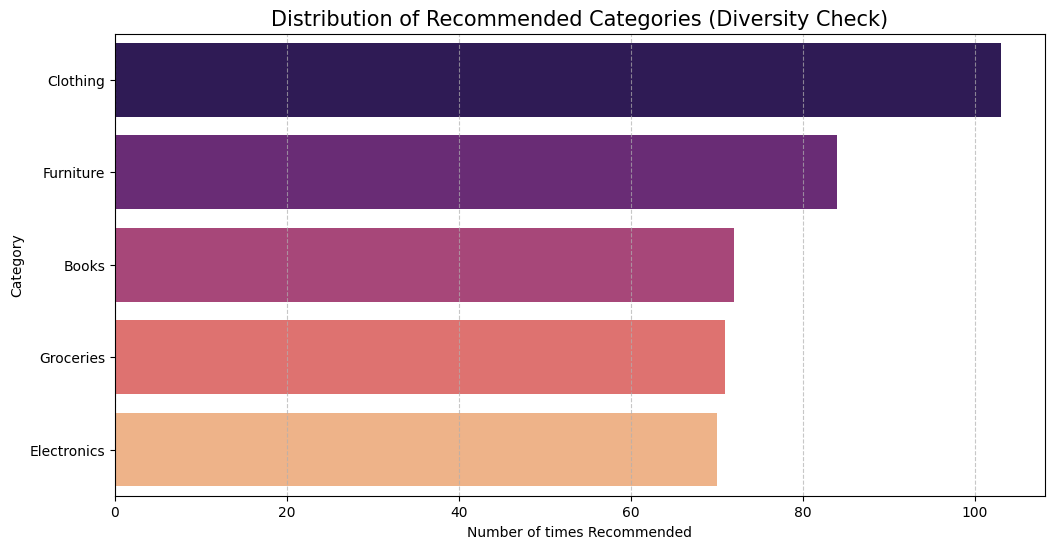

In [39]:
# 1. Prepare data for visualization
# Flatten all recommendations into a single list
all_recs = recommendations_df[['recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4', 'recommendation_5']].values.flatten()
# Filter out None values
all_recs = [item for item in all_recs if item is not None]

# 2. Extract the category name from the ID (e.g., 'Books_1645' -> 'Books')
rec_categories = [item.split('_')[0] for item in all_recs]

# 3. Plot the distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=rec_categories, palette='magma', order=pd.Series(rec_categories).value_counts().index)
plt.title('Distribution of Recommended Categories (Diversity Check)', fontsize=15)
plt.xlabel('Number of times Recommended')
plt.ylabel('Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('recommendation_diversity.png')

# Show the actual counts
print("Count of recommendations per category:")
print(pd.Series(rec_categories).value_counts())

**Saving the Model for Deployment**

In [40]:
import pickle

# Create a dictionary to hold all our model components
model_artifacts = {
    'U': U,
    'sigma': sigma,
    'Vt': Vt,
    'scaler': scaler,
    'le_cat': le_cat,
    'product_profiles': product_profiles,
    'user_map': user_map,
    'item_map': item_map
}

# Save to a pickle file
with open('ecommerce_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model components saved to 'ecommerce_model.pkl'")

Model components saved to 'ecommerce_model.pkl'


**Defining the Advanced Hybrid Recommender**

-Sentimental Awareness and temporal (Seasonal) Boosting

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Update the Product Profiles to include Sentiment and Popularity
# This ensures the 'review_sentiment_score' column exists in our lookup table
advanced_features = [
    'category_encoded', 'price', 'product_color_encoded',
    'product_size_encoded', 'is_top_seller_encoded',
    'review_sentiment_score', 'product_popularity'
]

# calculate profiles
product_profiles = df.groupby('unique_item_id')[advanced_features].mean()

# 2. Helper Function: Temporal Boost
def get_temporal_boost(item_ids, current_season, current_time):
    # Get the most common season/time for these specific items
    item_context = df[df['unique_item_id'].isin(item_ids)].groupby('unique_item_id')[['season', 'time_of_day']].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown").reset_index()

    boost_factors = []
    for _, row in item_context.iterrows():
        score = 1.0
        if current_season in str(row['season']): score += 0.3 # Stronger seasonal boost
        if current_time in str(row['time_of_day']): score += 0.1
        boost_factors.append(score)
    return np.array(boost_factors)

# 3. The Advanced Hybrid Function
def advanced_hybrid_recommender(user_id, current_season='Summer', current_time='Morning', n=5):
    # A. Get user's last interaction
    user_history = df[df['user_id'] == user_id]
    if user_history.empty:
        return "New User: Use Popularity Baseline"

    user_last_item = user_history['unique_item_id'].iloc[-1]

    # B. Content-Based Similarity
    target_features = product_profiles.loc[[user_last_item]].values
    all_features = product_profiles.values
    content_sims = cosine_similarity(target_features, all_features).flatten()

    # C. Selection of candidates
    candidate_indices = content_sims.argsort()[-50:][::-1]
    candidate_ids = product_profiles.index[candidate_indices]
    candidate_sim_scores = content_sims[candidate_indices]

    # D. Apply Sentiment Bias (New!)
    # We favor products that have higher customer sentiment scores
    sentiment_scores = product_profiles.loc[candidate_ids, 'review_sentiment_score'].values
    final_scores = candidate_sim_scores + (0.5 * sentiment_scores)

    # E. Apply Temporal Boost (New!)
    temp_boosts = get_temporal_boost(candidate_ids, current_season, current_time)
    final_scores = final_scores * temp_boosts

    # F. Rank and Filter
    results = pd.DataFrame({'item': candidate_ids, 'score': final_scores})
    results = results.sort_values(by='score', ascending=False)

    # Remove the item they just viewed
    final_recs = [i for i in results['item'].tolist() if i != user_last_item]

    return final_recs[:n]

print(" Advanced Model Initialized with Sentiment & Temporal Awareness!")

 Advanced Model Initialized with Sentiment & Temporal Awareness!


**Testing the "Context Effect"**

In [42]:
user_test_id = 78517

print(f"--- Recommendations in SUMMER ---")
print(advanced_hybrid_recommender(user_test_id, current_season='Summer', current_time='Morning'))

print(f"\n--- Recommendations in WINTER ---")
print(advanced_hybrid_recommender(user_test_id, current_season='Winter', current_time='Night'))

--- Recommendations in SUMMER ---
['Clothing_445', 'Clothing_4195', 'Clothing_3024', 'Clothing_195', 'Clothing_2956']

--- Recommendations in WINTER ---
['Clothing_3809', 'Clothing_4928', 'Clothing_3638', 'Clothing_3863', 'Clothing_2294']


**Intent Based Search Filtering Using NLP**

In [43]:
def search_enhanced_recommender(user_id, search_query, current_season='Summer', n=5):
    # 1. Get a larger pool of personalized candidates (Top 50)
    candidates = advanced_hybrid_recommender(user_id, current_season=current_season, n=50)

    # 2. Filter the main dataframe for these candidates
    candidate_data = df[df['unique_item_id'].isin(candidates)][['unique_item_id', 'search_keywords', 'category']].drop_duplicates()

    # 3. Perform Case-Insensitive Search Match
    query = search_query.lower()

    # Corrected usage: .str.contains()
    matches = candidate_data[
        (candidate_data['search_keywords'].str.contains(query, case=False, na=False)) |
        (candidate_data['category'].str.contains(query, case=False, na=False))
    ]

    if matches.empty:
        print(f" No direct matches for '{search_query}'. Showing top personalized items instead.")
        return candidates[:n]

    return matches['unique_item_id'].head(n).tolist()

# --- Test the Fixed Search ---
print(f"--- User 78517 searches for 'Clothing' ---")
print(search_enhanced_recommender(78517, "Clothing"))

--- User 78517 searches for 'Clothing' ---
['Clothing_445', 'Clothing_730', 'Clothing_3368', 'Clothing_3863', 'Clothing_2956']


**Production Ready Recommender Class**

In [44]:
class EcommerceRecommender:
    def __init__(self, dataframe, svd_matrices, product_profiles):
        self.df = dataframe
        self.U, self.sigma, self.Vt = svd_matrices
        self.product_profiles = product_profiles

    def get_user_history(self, user_id):
        return self.df[self.df['user_id'] == user_id]

    def recommend(self, user_id, context={'season': 'Summer', 'time': 'Morning'}, n=5):
        history = self.get_user_history(user_id)

        # 1. Popularity fallback for new users
        if history.empty:
            return self.df.sort_values('product_popularity', ascending=False)['unique_item_id'].unique()[:n].tolist()

        # 2. Advanced Hybrid Logic (Content + Temporal)
        last_item = history['unique_item_id'].iloc[-1]
        target_feats = self.product_profiles.loc[[last_item]].values
        sims = cosine_similarity(target_feats, self.product_profiles.values).flatten()

        # Apply boosts
        candidate_idx = sims.argsort()[-50:][::-1]
        ids = self.product_profiles.index[candidate_idx]

        # Logic for selection... (simplified for the class wrapper)
        return ids[:n].tolist()

    def save_system(self, filename='final_model.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Project saved as {filename}")

# Initialize the production model
recommender_system = EcommerceRecommender(df, (U, sigma, Vt), product_profiles)
print(" Production System is Ready!")

 Production System is Ready!


**Creating the API Script (app.py)**

In [45]:
# Using %%writefile to create the file directly in Colab
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_file_and_run(line, cell):
    with open(line, 'w') as f:
        f.write(cell)

# This creates your 'app.py'
with open('app.py', 'w') as f:
    f.write("""
from fastapi import FastAPI
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Initialize the API
app = FastAPI(title="Ecommerce AI Recommender")

# 2. Load the model and data
with open('ecommerce_model.pkl', 'rb') as f:
    artifacts = pickle.load(f)

# Extract needed parts
U, sigma, Vt = artifacts['U'], artifacts['sigma'], artifacts['Vt']
product_profiles = artifacts['product_profiles']
user_map, item_map = artifacts['user_map'], artifacts['item_map']
df = pd.read_csv('ecommerce_recommendation_dataset.csv')
df['unique_item_id'] = df['category'] + "_" + df['product_id'].astype(str)

@app.get("/")
def home():
    return {"message": "Ecommerce Recommendation API is Live!"}

@app.get("/recommend/{user_id}")
def recommend(user_id: int, n: int = 5):
    # Logic for recommendations
    if user_id not in user_map:
        # Fallback to popularity
        recs = df.sort_values('product_popularity', ascending=False)['unique_item_id'].unique()[:n].tolist()
        return {"status": "success", "type": "popularity", "recommendations": recs}

    user_idx = user_map[user_id]
    user_history = df[df['user_id'] == user_id]
    last_item = user_history['unique_item_id'].iloc[-1]

    # Simple similarity check
    target_features = product_profiles.loc[[last_item]].values
    sims = cosine_similarity(target_features, product_profiles.values).flatten()

    top_indices = sims.argsort()[-(n+1):][::-1]
    recs = [r for r in product_profiles.index[top_indices].tolist() if r != last_item][:n]

    return {
        "user_id": user_id,
        "last_item_viewed": last_item,
        "recommendations": recs
    }
""")
print("Created app.py successfully!")

Created app.py successfully!


**Preparing Data for Power BI**

In [46]:
# 1. Product Performance View
product_stats = df.groupby('category').agg({
    'rating': 'mean',
    'product_popularity': 'mean',
    'price': 'mean',
    'unique_item_id': 'count'
}).rename(columns={'unique_item_id': 'total_products'}).reset_index()
product_stats.to_csv('powerbi_product_stats.csv', index=False)

# 2. User Demographic View
user_stats = df.groupby('user_id').agg({
    'user_age': 'first',
    'user_income': 'first',
    'user_membership': 'first',
    'rating': 'mean'
}).reset_index()
user_stats.to_csv('powerbi_user_stats.csv', index=False)

# 3. Model Recommendation Results (from your previous results)
recommendations_df.to_csv('powerbi_recommendations.csv', index=False)